In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [5]:
from os import cpu_count
import multiprocessing as mp
print(mp.cpu_count())

import psutil
print(psutil.cpu_count(logical=False))

10
10


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))]
)

In [7]:
training_set = torchvision.datasets.FashionMNIST(
    './fashion_mnist_data/', train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.FashionMNIST(
    './fashion_mnist_data/', train=False, transform=transform, download=True
)

In [8]:
training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=4, shuffle=True
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=True
)

In [9]:
classes = (
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
)

In [10]:
print(f"Training set has {len(training_set)} records")
print(f"Validation set has {len(validation_set)} records")

Training set has 60000 records
Validation set has 10000 records


In [11]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


Bag Ankle Boot Shirt Coat


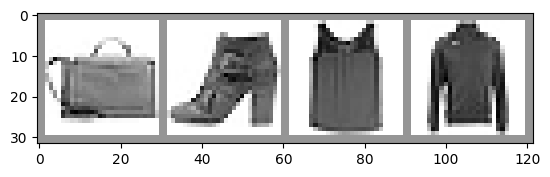

In [12]:
def matplotlib_imshow(img, one_channel=False):
    """
    Helper function for inline image display
    """
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(' '.join(classes[labels[j]] for j in range(4)))

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = GarmentClassifier()

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])

loss = loss_fn(dummy_outputs, dummy_labels)
print(f"Total loss for this batch: {loss.item()}")

Total loss for this batch: 2.3695340156555176


In [17]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.001, momentum=0.9
)

In [18]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0

    for index, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

        if index % 1000 == 999:
            last_loss = running_loss / 1000
            print(f"Batch-{index+1} loss: {last_loss}")
            tb_x = epoch_index * len(training_loader) + index + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0

    return last_loss

In [19]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f"runs/fashion_trainer_{timestamp}")
EPOCHS = 5
best_vloss = 1_000_000

for epoch in range(1, EPOCHS+1):
    print(f"EPOCH {epoch}")
    model.train(True)
    avg_loss = train_one_epoch(epoch, writer)
    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for index, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print(f"Loss train: {avg_loss} valid: {avg_vloss}")
    writer.add_scalars(
        'Training vs. Validation Loss',
        {'Training': avg_loss, 'Validation': avg_vloss},
        epoch
    )
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f"models/model_{timestamp}_{epoch}"
        torch.save(model.state_dict(), model_path)

EPOCH 1
Batch-1000 loss: 1.579756259918213
Batch-2000 loss: 0.830723762512207
Batch-3000 loss: 0.71454918384552
Batch-4000 loss: 0.6659244298934937
Batch-5000 loss: 0.6089029908180237
Batch-6000 loss: 0.5587291717529297
Batch-7000 loss: 0.5373756289482117
Batch-8000 loss: 0.48237931728363037
Batch-9000 loss: 0.47630810737609863
Batch-10000 loss: 0.4507363438606262
Batch-11000 loss: 0.4684612452983856
Batch-12000 loss: 0.45937544107437134
Batch-13000 loss: 0.4359118640422821
Batch-14000 loss: 0.4477478265762329
Batch-15000 loss: 0.41084569692611694
Loss train: 0.41084569692611694 valid: 0.4787847101688385
EPOCH 2
Batch-1000 loss: 0.41752299666404724
Batch-2000 loss: 0.4079087972640991
Batch-3000 loss: 0.3982095718383789
Batch-4000 loss: 0.3855656385421753
Batch-5000 loss: 0.3927559554576874
Batch-6000 loss: 0.40198543667793274
Batch-7000 loss: 0.3834165334701538
Batch-8000 loss: 0.37857988476753235
Batch-9000 loss: 0.3717985451221466
Batch-10000 loss: 0.35839027166366577
Batch-11000 los